<a href="https://colab.research.google.com/github/WaterForTansania/WFT/blob/master/WaterForTansania.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd # pandas to read the dataset
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import statsmodels.api as sm

from numpy import nan #To find missing values
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import chi2,f_classif,SelectKBest, VarianceThreshold
import datetime
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from google.colab import files


# **DATA EXPLAINING**


## Read

Read the target values dataset from the drivendata link.

In [ ]:
url = 'https://s3.amazonaws.com/drivendata-prod/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
df_labels = pd.read_csv(url)

Read the test values dataset from drivendata link

In [ ]:
url = 'https://s3.amazonaws.com/drivendata-prod/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'
df_test_values = pd.read_csv(url)

Read the training values dataset from the drivendata link.

In [ ]:
url = "https://s3.amazonaws.com/drivendata-prod/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv"
df_values = pd.read_csv(url)

## Look of training dataset 

In [ ]:
df_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## Description for training dataset.

In [ ]:
df_values.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Target values in dataset is in the form of :

In [ ]:
df_labels

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


## Plotting target values with percentages.

Text(0, 0.5, ' ')

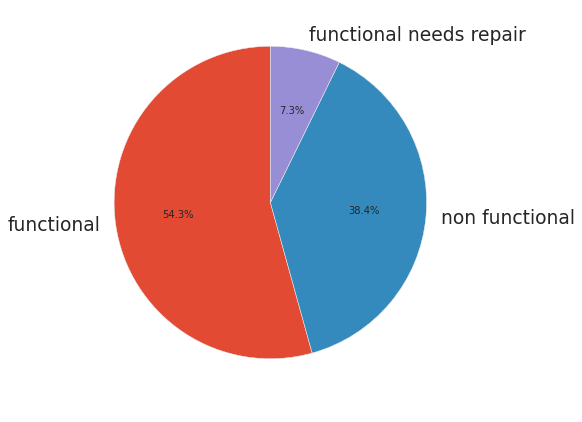

In [ ]:
per_plot = df_labels['status_group'].value_counts().plot.pie(autopct='%1.1f%%',
        shadow=False, startangle=90 , figsize=(7,13))
per_plot.set_xlabel(" ")
per_plot.set_ylabel(" ")

Merged the label and target dataset to df_merged.

In [ ]:
df_merged = df_labels.merge(df_values)
df_region = df_merged.fillna("unknown")
df_region = df_region.loc[:, ['region', 'status_group']]
df_region.head()

,region,status_group
0,Iringa,functional
1,Mara,functional
2,Manyara,functional
3,Mtwara,non functional
4,Kagera,functional


Used the merged dataset for plotting

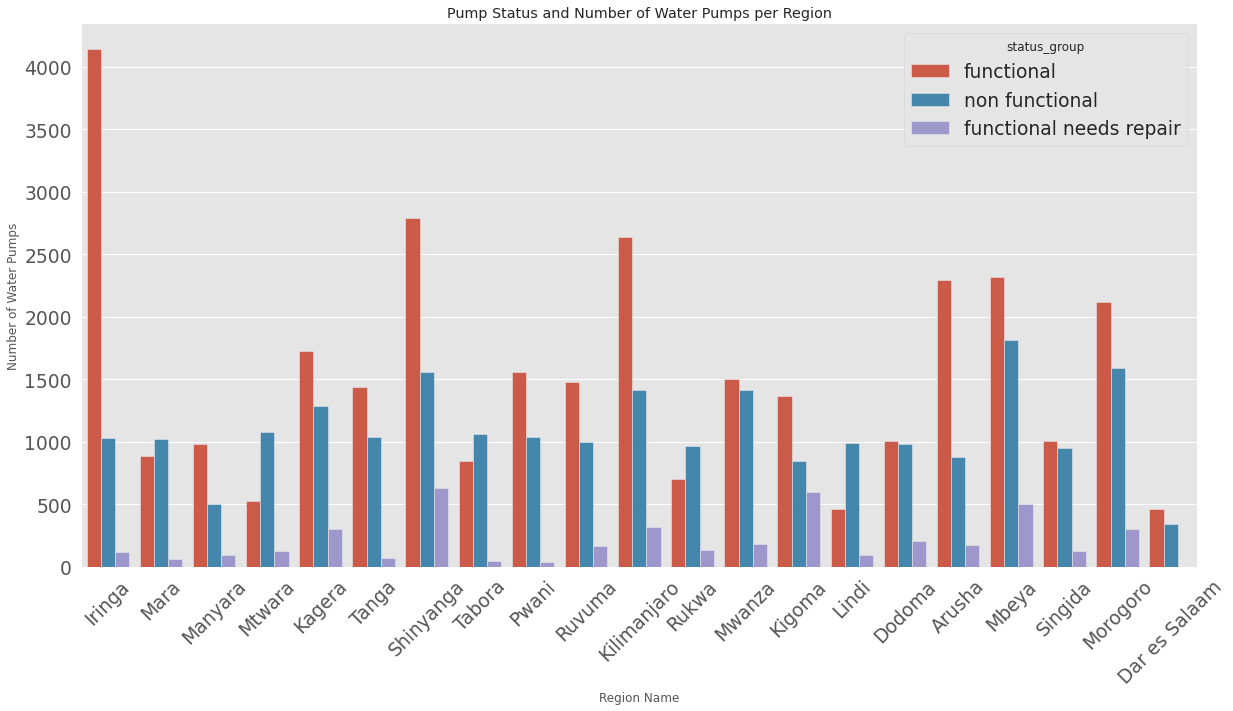

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data=df_region, x='region', hue='status_group')

ax.set(xlabel='Region Name', ylabel='Number of Water Pumps', title='Pump Status and Number of Water Pumps per Region')

sns.set(font_scale=1.7)
plt.xticks(rotation=45);

## Missing Values

Missing values for training data.

In [ ]:
missing_values_count = df_values.isnull().sum()
missing_values_count

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

Missing values for test data.

In [ ]:
missing_values_test_count = df_test_values.isnull().sum()
missing_values_test_count

id                          0
amount_tsh                  0
date_recorded               0
funder                    869
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

Propotion of missing_values of all data.

In [ ]:
# how many total missing values do we have?
total_cells = np.product(df_values.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100

1.939983164983165

# **DATA MANIPULATING**

Filling empty values with keyword "unknown"

In [ ]:
df_values = df_values.fillna("unknown")
df_test_values = df_test_values.fillna("unknown")

Concatenating test and training data
This will allow us to make changes for both test and training datas
We will seperate them after data manipulation

In [ ]:
frames = [df_values, df_test_values]
df_values = pd.concat(frames)

Trimming(deleting whitespaces)

In [ ]:
df_values[df_values.columns] = df_values.apply(lambda x: x if type(x)!=str else x.str.strip())

In [ ]:
# Value is missing because it wasn't recorded or because it doesn't exist?
# If value is missing, keep it Nan, if it wasn't recorded then you can try to guess, called as imputation! 

# Remove all the rows that contain a missing value
# df_values.dropna()

# remove all columns with at least one missing value
# columns_with_na_dropped = df_values.dropna(axis=1)
# columns_with_na_dropped.head()

# just how much data did we lose?
# print("Columns in original dataset: %d \n" % df_values.shape[1])
# print("Columns with na's dropped: %d" % columns_with_na_dropped.shape[1])

Make all values lower case in each row to make the changes easier.

In [ ]:
for key in df_values.keys():
    df_values[key] = df_values[key].map(lambda x: x if type(x)!=str else x.lower())


## Feature Observations

### amount_tsh, num_private

the percentage of zeros in amount_tsh,num_private

In [ ]:
amount_tsh_percentage = (df_values.amount_tsh == 0).sum() / len(df_values['amount_tsh']) *100
num_private_percentage = (df_values.num_private == 0).sum() / len(df_values['num_private']) *100

print("percentage of 0's in amount_tsh: %f\npercentage of 0's in num_private:" % amount_tsh_percentage,num_private_percentage)

percentage of 0's in amount_tsh: 70.099663
percentage of 0's in num_private: 98.71919191919191


So, these columns could be deleted

### region, region_code

correlation between region and region_code

In [ ]:
s = LabelEncoder().fit_transform(df_values['region'])
s = pd.DataFrame(s)
matplotlib.style.use('ggplot')


### construction_year, year_recorded

can converge

## Column Specific Data Manipulation

### construction_year, year_recorded

Changed all rows with 0 value on construction_year to mean of non-zero rows.

In [ ]:
df_values_copy = df_values['construction_year'].copy()
df_values_copy = df_values_copy[df_values_copy != 0]
df_values['construction_year'] = df_values['construction_year'].replace(0, int(df_values_copy.mean()))

Added new column using construction year and year recorded to have a meaningful column. Dropped construction year,year recorded columns and the columns that are added inside of the method.

In [ ]:
def date_parser(df):
    date_recorder = list(map(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d'),
                             df['date_recorded'].values))
    df['year_recorder'] = list(map(lambda x: int(x.strftime('%Y')), date_recorder))
    df['weekday_recorder'] = list(map(lambda x: int(x.strftime('%w')), date_recorder))
    df['yearly_week_recorder'] = list(map(lambda x: int(x.strftime('%W')), date_recorder))
    df['month_recorder'] = list(map(lambda x: int(x.strftime('%m')), date_recorder))
    df['age'] = df['year_recorder'].values - df['construction_year'].values
    del df['date_recorded']
    del df['weekday_recorder']
    del df['yearly_week_recorder']
    del df['construction_year']
    del df['month_recorder']
    del df['year_recorder']
    return df

In [ ]:
df_values = date_parser(df_values)

In [ ]:
df_values

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age
0,69572,6000.0,roman,1390,roman,34.938093,-9.856322,none,0,lake nyasa,mnyusi b,iringa,11,5,ludewa,mundindi,109,True,geodata consultants ltd,vwc,roman,False,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,12
1,8776,0.0,grumeti,1399,grumeti,34.698766,-2.147466,zahanati,0,lake victoria,nyamara,mara,20,2,serengeti,natta,280,unknown,geodata consultants ltd,other,unknown,True,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,3
2,34310,25.0,lottery club,686,world vision,37.460664,-3.821329,kwa mahundi,0,pangani,majengo,manyara,21,4,simanjiro,ngorika,250,True,geodata consultants ltd,vwc,nyumba ya mungu pipe scheme,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,4
3,67743,0.0,unicef,263,unicef,38.486161,-11.155298,zahanati ya nanyumbu,0,ruvuma / southern coast,mahakamani,mtwara,90,63,nanyumbu,nanyumbu,58,True,geodata consultants ltd,vwc,unknown,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,27
4,19728,0.0,action in a,0,artisan,31.130847,-1.825359,shuleni,0,lake victoria,kyanyamisa,kagera,18,1,karagwe,nyakasimbi,0,True,geodata consultants ltd,unknown,unknown,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,danida,34,da,38.852669,-6.582841,kwambwezi,0,wami / ruvu,yombo,pwani,6,1,bagamoyo,yombo,20,True,geodata consultants ltd,vwc,bagamoyo wate,True,mono,mono,motorpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,23
14846,18990,1000.0,hiap,0,hiap,37.451633,-5.350428,bonde la mkondoa,0,pangani,mkondoa,tanga,4,7,kilindi,mvungwe,2960,True,geodata consultants ltd,vwc,unknown,False,nira/tanira,nira/tanira,handpump,vwc,user-group,pay annually,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,17
14847,28749,0.0,unknown,1476,unknown,34.739804,-4.585587,bwawani,0,internal,juhudi,singida,13,2,singida rural,ughandi,200,True,geodata consultants ltd,vwc,unknown,unknown,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,3
14848,33492,0.0,germany,998,dwe,35.432732,-10.584159,kwa john,0,lake nyasa,namakinga b,ruvuma,10,2,songea rural,maposeni,150,True,geodata consultants ltd,vwc,mradi wa maji wa maposeni,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,4


###recorded_by 

In [ ]:
del df_values['recorded_by']

## Dictionaries to manipulate data

A general dictionary which is replaces unknown type words to "unknown" keyword.

In [ ]:
unknowns_dictionary = {
  "not-known": "unknown",
  "not-kno": "unknown",
  "no": "unknown",
  "no scheme": "unknown",
  "none": "unknown",
  #"-": "unknown",
  "not known": "unknown"
}
df_values = df_values.replace(unknowns_dictionary)


In [ ]:
funder_dictionary = {
  "a/co germany": "aco/germany",
  "acord ngo": "acord",
  "act-mara": "act",
  "adp bungu": "adp",
  "adp mombo": "adp",
  "adp/w": "adp",
  "afric": "africa",
  "aict": "aic",
  "ai": "aic",
  "aic church": "aic",
  "aic kij": "aic",
  "amref": "amrefe",
  "apm[africa precious metal lt": "apm",
  "arabs community": "arab community",
  "baptest ": "baptist",
  "baptist church": "baptist",
  "batist church": "baptist",
  "bingo foundation germany": "bingo foundation",
  "boazi": "boazi /o",
  "bread for the wor": "bread for the worl",
  "bukwang church saints": "bukwang church saint",
  "buptist": "baptist",
  "caltus":"caltas",
  "care int":"care international",
  "cdtfdistrict counsil":"cdtf",
  "ces(gmbh)":"ces (gmbh)",
  "cg":"cg/rc",
  "chacha issame":"chacha",
  "chani":"china",
  "cheni":"china",
  "christan outrich":"christian outrich",
  "cristan outrich" : "christian outrich",
  "chuo":"church",
  "churc":"church",
  "church of disciples":"church",
  "cheni":"china",
  ##TODO
}

In [ ]:
installer_dictionary = {
    "-" : "unknown",
    "0": "unknown",
    "active tank co ltd": "active tank co",
    "aaa": "a.a.a",
    "adra /aommunity" : "adra/community",
    "adra/ aommunity" : "adra/community",
    "adrs": "adra",
    "adra /government" : "adra/government",
    "amp contractor" : "amp contract",
    "amp contracts" : "amp contract",
    "anglica church" : "anglican church",
    "arabs community": "arab community",
    "ardhi water wells": "ardhi water well",
    "atlas" : "atlas company",
    "babu sajini" : "babu sajin",
    "baptist church of tanzania": "baptist church",
    "batist church": "baptist church",
    "babtest" : "baptist church",
    "britain" : "british",
    "british colonial government" : "british government",
    "building works engineering ltd" : "building works company ltd",
    "care  international" : "care international",
    "cheni" : "china",
    "china co." : "china",
    "china henan constuction" : "china henan constractor",
    "chinese" : "china",
    "cristan outrich" : "christian outrich",
    "christan outrich" : "christian outrich",
    "churc" : "church",
    "chuo":"church",
    "church of disciples" : "church",
    "commu" : "community",
    "compa" : "company",
    "communit" : "community",
    "comunity" : "community",
    "conce" : "concern",
    "concen" : "concern",
    "concern /government" : "concern/government",
    "consulting engineer" : "consultant engineer",
    "consuting engineer" : "consultant engineer",
    "consultant" : "consultant engineer",
    "contr" : "conta",
    "counc":"council",
    "distri" : "district council",
    "district counci" : "district council",
    "district water depar" : "district water department",
    "dr. matobola" : "dr.matobola",
    "dr. matomola" : "dr.matomola",
    "fini water" : "finwater",
    "fin water" : "finwater",
    "finn water" : "finwater",
    "finwter" : "finwater",
    "finw" : "finwater",
    "german missionary" : "germany missionary",
    "gold star" : "goldstar",
    "gove": "government",
    "gover": "government",
    "govern": "government",
    "gwaseco" : "gwasco",
    "gwasco l" : "gwasco",
    "handeni trunk main(" : "handeni trunk main",
    "hesawa" : "hesewa",
    "heasawa" : "hesewa",
    "individual person" : "individual",
    "individuals" : "individual",
    "italy government" : "italian government",
    ##TODO
}

## Encoding

Casting boolean type columns to string

In [ ]:
df_values["public_meeting"] = df_values["public_meeting"].astype(str)
df_values["permit"] = df_values["permit"].astype(str)

### A class to encode multiple columns with LabelEncoder

In [ ]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

### Encoding string type features using LabelEncoder

In [ ]:
df_values = MultiColumnLabelEncoder(columns = ['funder',
                                   'installer',
                                   'wpt_name',
                                   'basin',
                                   'subvillage',
                                   'region',
                                   'lga',
                                   'ward',
                                   'public_meeting',
                                   'scheme_management',
                                   'scheme_name',
                                   'permit',
                                   'extraction_type',
                                   'extraction_type_group',
                                   'extraction_type_class',
                                   'management',
                                   'management_group',
                                   'payment', 
                                   'payment_type',
                                   'water_quality',
                                   'quality_group',
                                   'quantity',
                                   'quantity_group',
                                   'source',
                                   'source_type',
                                   'source_class',
                                   'waterpoint_type',
                                   'waterpoint_type_group']).fit_transform(df_values)

### Splitting test and training datas that we have merged

In [ ]:
train_data = df_values.iloc[0:59400]

In [ ]:
train_data

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age
0,69572,6000.0,1545,1390,1578,34.938093,-9.856322,44772,0,1,13116,3,11,5,51,1429,109,1,7,2318,0,3,1,0,7,4,2,0,6,2,1,1,8,6,0,1,1,12
1,8776,0.0,522,1399,592,34.698766,-2.147466,45423,0,4,17596,9,20,2,103,1581,280,2,1,2591,1,3,1,0,11,4,0,2,6,2,2,2,5,3,1,1,1,3
2,34310,25.0,924,686,2124,37.460664,-3.821329,17767,0,5,10096,8,21,4,108,1629,250,1,7,2197,1,3,1,0,7,4,4,5,6,2,1,1,0,1,1,2,1,4
3,67743,0.0,1958,263,1958,38.486161,-11.155298,45534,0,7,9998,12,90,63,87,1576,58,1,7,2591,1,14,10,5,7,4,0,2,6,2,0,0,3,0,0,2,1,27
4,19728,0.0,20,0,114,31.130847,-1.825359,43408,0,4,8583,4,18,1,26,1692,0,1,6,2591,1,3,1,0,1,1,0,2,6,2,3,3,5,3,1,1,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,486,1210,234,37.169807,-3.253847,633,0,5,6315,6,3,5,16,1092,125,1,9,1118,1,3,1,0,9,4,4,5,6,2,1,1,8,6,0,1,1,14
59396,27263,4700.0,196,1212,223,35.249991,-9.070629,29455,0,6,3323,3,11,4,91,354,56,1,7,496,1,3,1,0,7,4,2,0,6,2,1,1,6,4,1,1,1,15
59397,37057,0.0,1970,0,1963,34.017087,-8.750434,34135,0,6,9784,10,12,7,59,177,0,1,7,2591,0,15,11,1,7,4,3,1,1,1,1,1,3,0,0,4,3,15
59398,31282,0.0,992,0,1261,35.861315,-6.378573,36304,0,6,15553,2,1,4,11,1452,0,1,7,2591,1,8,5,1,7,4,0,2,6,2,2,2,7,5,0,4,3,15


In [ ]:
test_data = df_values.iloc[59400:len(df_values)]

In [ ]:
test_data

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age
0,50785,0.0,345,1996,411,35.290799,-4.059696,2669,0,0,9934,8,21,3,63,18,321,1,2,2591,1,9,6,3,3,2,0,2,6,2,3,3,5,3,1,6,5,1
1,51630,0.0,507,1569,434,36.656709,-3.309214,7473,0,5,6897,0,2,2,0,693,300,1,7,2544,1,3,1,0,7,4,0,2,6,2,2,2,8,6,0,1,1,13
2,17168,0.0,1970,1567,1963,34.767863,-5.004344,41109,0,0,13539,18,13,2,109,1792,500,1,7,2250,2,9,6,3,7,4,0,2,6,2,2,2,5,3,1,6,5,3
3,45559,0.0,443,267,507,38.058046,-9.418672,24064,0,7,7143,7,80,43,49,1283,250,2,7,2591,1,9,6,3,7,4,6,6,6,2,0,0,7,5,0,6,5,26
4,49871,500.0,150,1260,182,35.006123,-10.950412,24521,0,7,9033,16,10,3,61,1157,60,2,9,183,1,3,1,0,9,4,3,1,6,2,1,1,8,6,0,1,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,293,34,343,38.852669,-6.582841,30976,0,8,21328,14,6,1,3,2087,20,1,7,28,1,7,4,2,7,4,0,2,6,2,1,1,6,4,1,1,1,23
14846,18990,1000.0,584,0,656,37.451633,-5.350428,1352,0,5,12687,20,4,7,33,1454,2960,1,7,2591,0,8,5,1,7,4,2,0,4,4,2,2,7,5,0,4,3,17
14847,28749,0.0,1970,1476,1963,34.739804,-4.585587,1821,0,0,4755,18,13,2,109,1999,200,1,7,2591,2,3,1,0,7,4,0,2,6,2,2,2,0,1,1,1,1,3
14848,33492,0.0,482,998,434,35.432732,-10.584159,14467,0,1,15803,16,10,2,111,1072,150,1,7,1708,1,3,1,0,7,4,0,2,6,2,2,2,6,4,1,1,1,4


## General Data Manipulation

### Pearson Correlation


The correlation coefficient has values between -1 to 1

— A value closer to 0 implies weaker correlation (exact 0 implying no correlation)

— A value closer to 1 implies stronger positive correlation

— A value closer to -1 implies stronger negative correlation

(https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)


Using pearson correlation to show all the correlations between features

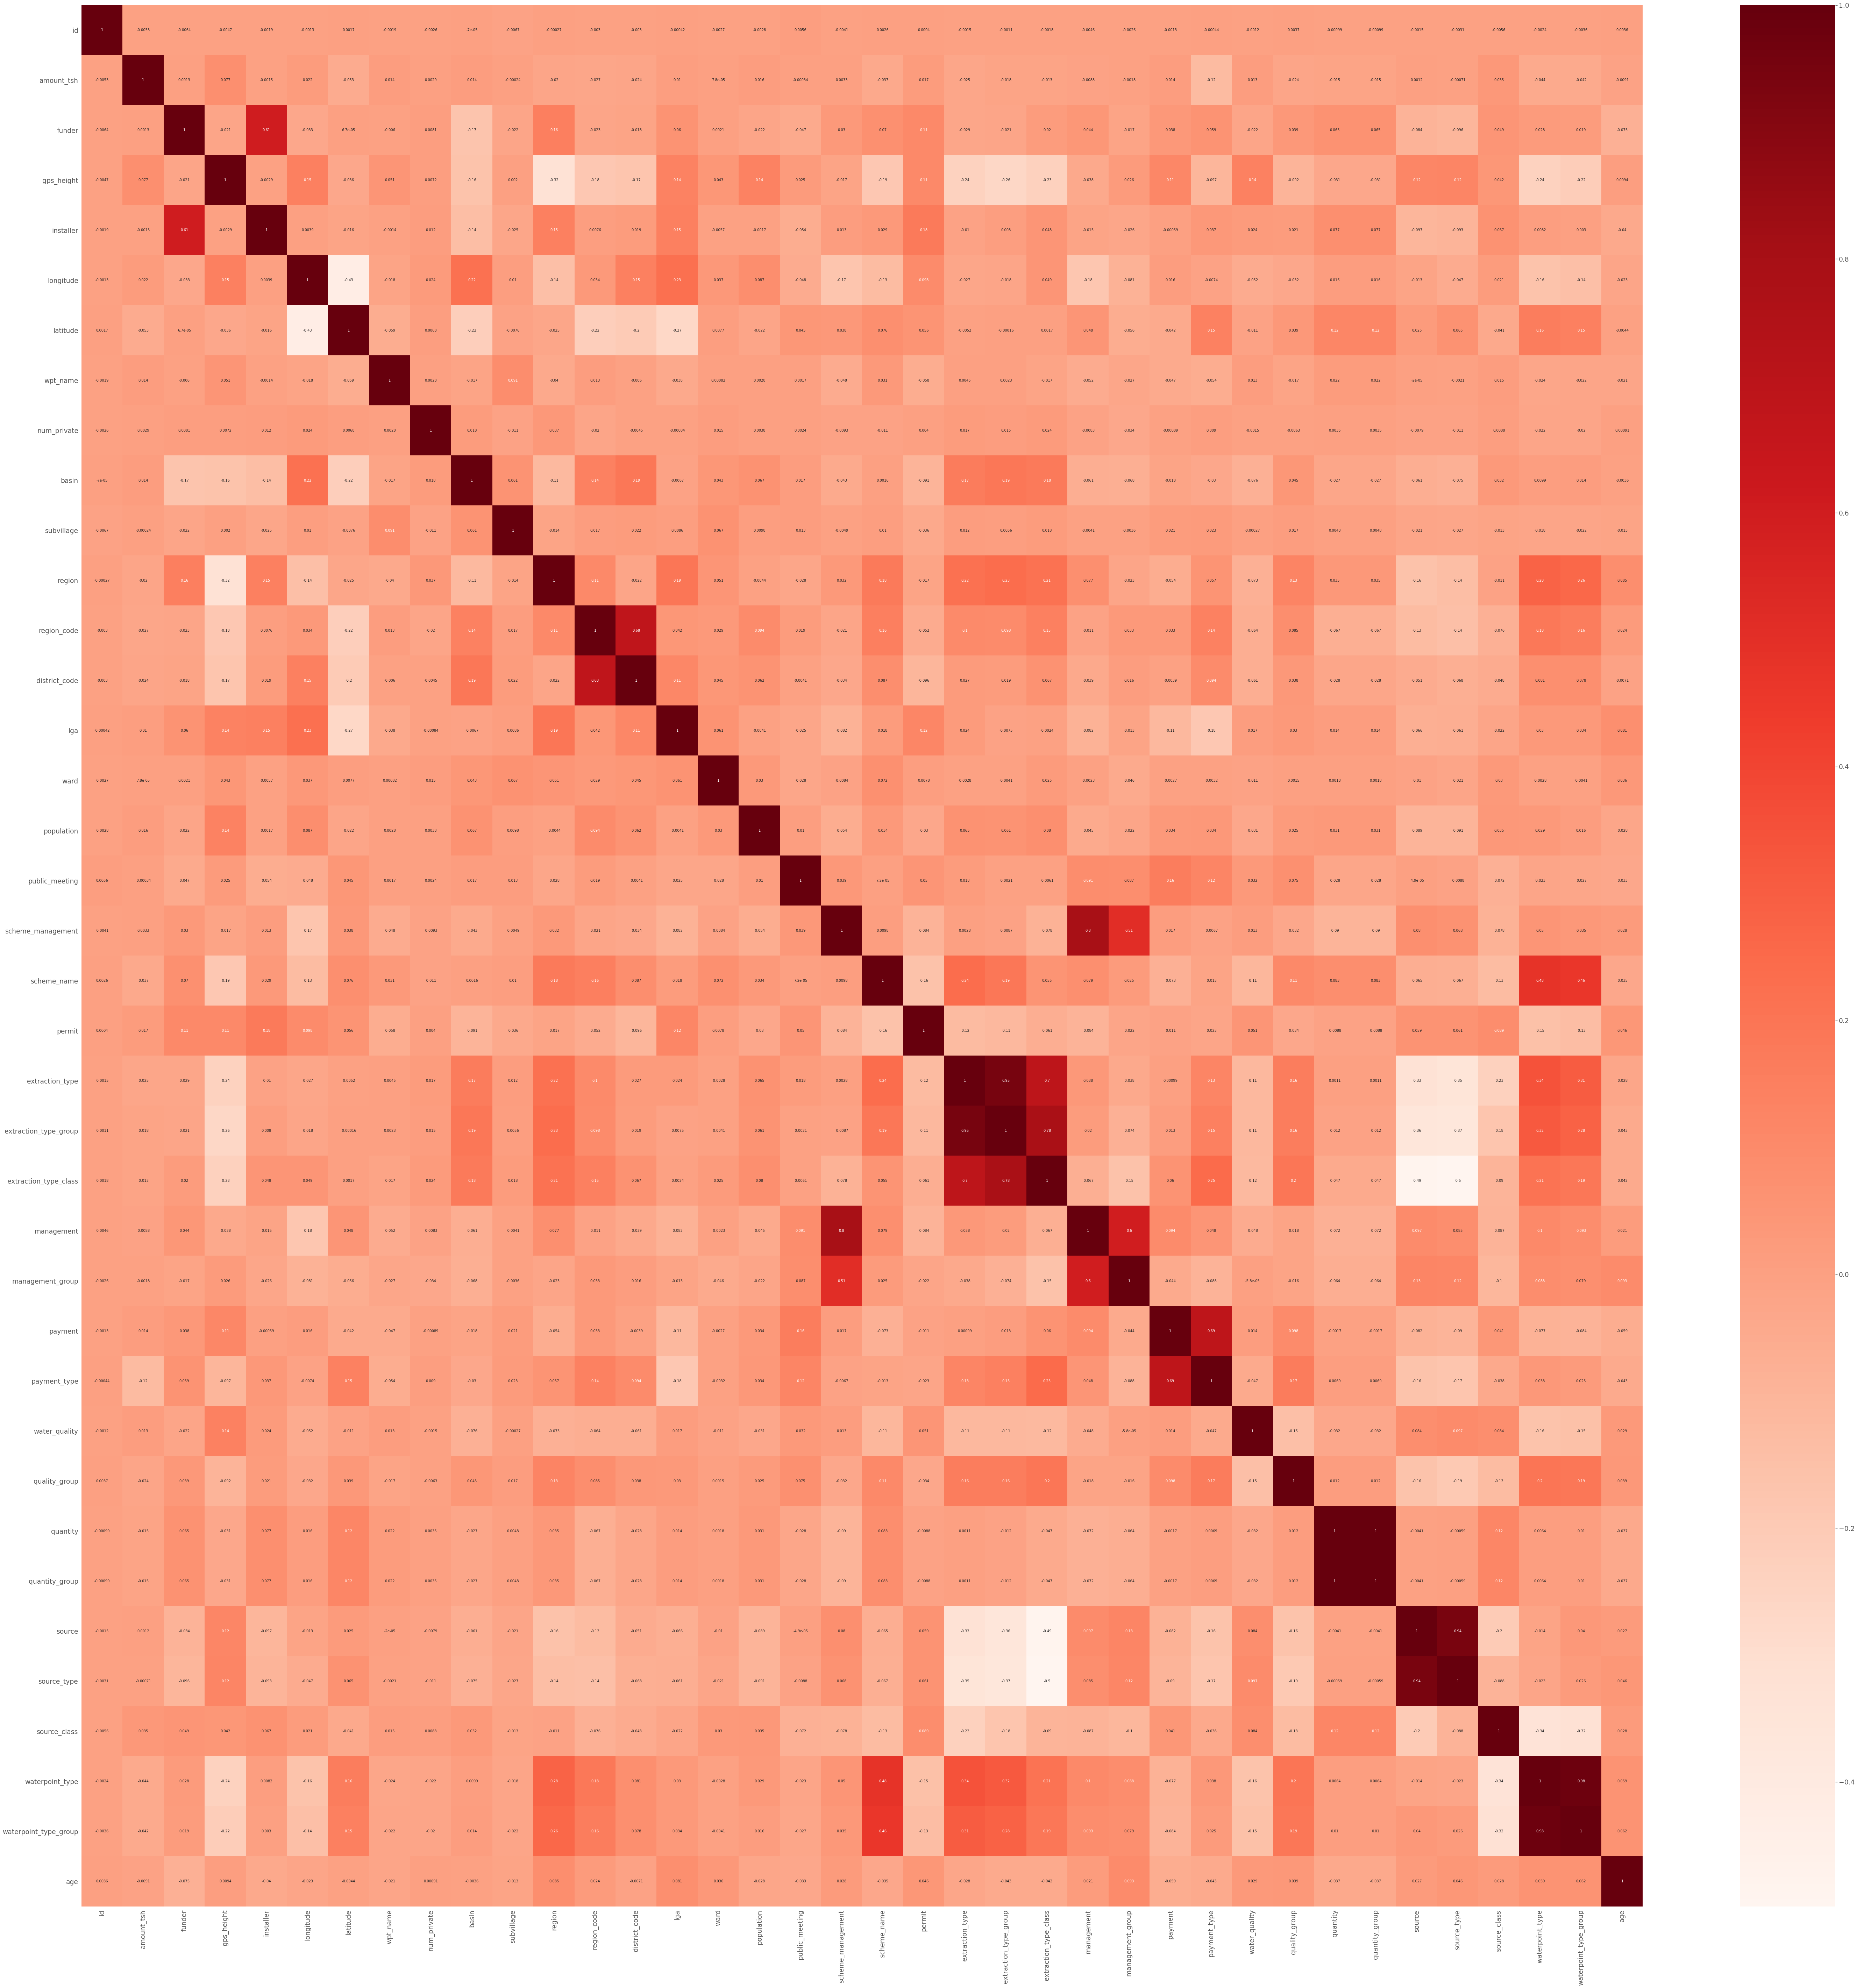

In [ ]:
plt.figure(figsize=(100,100))

cor = train_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

By using values found from pearson correlation, we iterate each feature to find all combinations of correlations

In [ ]:
def find_correlation(f,c):
  for i in train_data.keys():
    for i2 in train_data.keys():
      if(i != i2):
        correlation = train_data[[i,i2]].corr()
        cor_between = float (correlation.iloc[0,1])
        if((f <= abs(cor_between)) and (abs(cor_between) <= c)):
          print("Correlation between %s and %s : %f" % (i,i2,cor_between))

Features with very high correlation

In [ ]:
find_correlation(0.9,1)

Correlation between extraction_type and extraction_type_group : 0.949524
Correlation between extraction_type_group and extraction_type : 0.949524
Correlation between quantity and quantity_group : 1.000000
Correlation between quantity_group and quantity : 1.000000
Correlation between source and source_type : 0.943818
Correlation between source_type and source : 0.943818
Correlation between waterpoint_type and waterpoint_type_group : 0.982154
Correlation between waterpoint_type_group and waterpoint_type : 0.982154


Features with high correlation

In [ ]:
find_correlation(0.6,0.9)

Correlation between funder and installer : 0.607049
Correlation between installer and funder : 0.607049
Correlation between region_code and district_code : 0.678602
Correlation between district_code and region_code : 0.678602
Correlation between scheme_management and management : 0.795872
Correlation between extraction_type and extraction_type_class : 0.695052
Correlation between extraction_type_group and extraction_type_class : 0.784300
Correlation between extraction_type_class and extraction_type : 0.695052
Correlation between extraction_type_class and extraction_type_group : 0.784300
Correlation between management and scheme_management : 0.795872
Correlation between payment and payment_type : 0.685673
Correlation between payment_type and payment : 0.685673


Removing one of columns with high correlation, ID, and columns that are mostly blank(amount_tsh,num_private)

In [ ]:
def removal(X_train, X_test):
    z = ['id','amount_tsh',  'num_private', 'region'
        , 'quality_group', 'source_type', 'payment', 
          'waterpoint_type_group', 
         'extraction_type_group']
    for i in z:
        del X_train[i]
        del X_test[i]
    return X_train, X_test

#train_data,test_data= removal(train_data, test_data)


###gps_height, latitude, longitude

These values are all connected so we can do a linear discriminant analysis to them to reduce dimension

In [ ]:
def lda(X_train, X_test, y_train, cols=['gps_height', 'latitude', 'longitude']):
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train[cols])
    X_test_std = sc.transform(X_test[cols])
    lda = LDA(n_components=None)

    X_train_lda = lda.fit_transform(X_train_std, y_train['status_group'])
    print(X_train_lda)
    X_test_lda = lda.transform(X_test_std)
    X_train = pd.concat((pd.DataFrame(X_train_lda), X_train), axis=1)
    X_test = pd.concat((pd.DataFrame(X_test_lda), X_test), axis=1)
    for i in cols:
        del X_train[i]
        del X_test[i]
    return X_train, X_test

call the lda function

In [ ]:

#train_data,test_data= lda(train_data, test_data, df_labels)


In [ ]:
#Delete
def locs(X_train, X_test):
    trans = ['longitude', 'latitude', 'gps_height', 'population']
    for i in [X_train, X_test]:
        i.loc[i.longitude == 0, 'latitude'] = 0
    for z in trans:
        for i in [X_train, X_test]:
            i[z].replace(0., np.NaN, inplace = True)
            i[z].replace(1., np.NaN, inplace = True)
        
        for j in ['subvillage', 'district_code', 'basin']:
        
            X_train['mean'] = X_train.groupby([j])[z].transform('mean')
            X_train[z] = X_train[z].fillna(X_train['mean'])
            o = X_train.groupby([j])[z].mean()
            fill = pd.merge(X_test, pd.DataFrame(o), left_on=[j], right_index=True, how='left').iloc[:,-1]
            X_test[z] = X_test[z].fillna(fill)
        
        X_train[z] = X_train[z].fillna(X_train[z].mean())
        X_test[z] = X_test[z].fillna(X_train[z].mean())
        del X_train['mean']
    return X_train, X_test

In [ ]:

#train_data, test_data = locs(train_data, test_data )
#train_data


All values are the same needs to be deleted before selectio to supress warnings.It is not logical to keep anyway.

### Feature Selection with forward selection using Random Forest

In [ ]:
'''
best_accuracy_forward = 0
best_model_feature_size_forward = 0

rf = RandomForestClassifier(n_estimators = 200, random_state = 42)

for i in range(1,len(train_data.columns)):
  train_data_k = SelectKBest(f_classif, k=i).fit_transform(train_data, df_labels['status_group'])
  Kfold = cross_val_score(rf, train_data_k, df_labels['status_group'], cv=5)
  accuracy = Kfold.mean()
  print("feature size :", i ,"rf : decision tree's with 200 , Accuracy: %0.4f (+/- %0.2f)" % (Kfold.mean(), Kfold.std() * 2))
  if (accuracy > best_accuracy_forward):
    best_accuracy_forward = accuracy
    best_model_feature_size = i
  

print("Best accuracy achieved with forward selection is : " ,best_accuracy_forward)
print("K value for the feature size that Best accuracy achieved with forward selection is : " ,best_model_feature_size)
'''

'\nbest_accuracy_forward = 0\nbest_model_feature_size_forward = 0\n\nrf = RandomForestClassifier(n_estimators = 200, random_state = 42)\n\nfor i in range(1,len(train_data.columns)):\n  train_data_k = SelectKBest(f_classif, k=i).fit_transform(train_data, df_labels[\'status_group\'])\n  Kfold = cross_val_score(rf, train_data_k, df_labels[\'status_group\'], cv=5)\n  accuracy = Kfold.mean()\n  print("feature size :", i ,"rf : decision tree\'s with 200 , Accuracy: %0.4f (+/- %0.2f)" % (Kfold.mean(), Kfold.std() * 2))\n  if (accuracy > best_accuracy_forward):\n    best_accuracy_forward = accuracy\n    best_model_feature_size = i\n  \n\nprint("Best accuracy achieved with forward selection is : " ,best_accuracy_forward)\nprint("K value for the feature size that Best accuracy achieved with forward selection is : " ,best_model_feature_size)\n'

In [ ]:
'''
selector = SelectKBest(f_classif, k=36)
train_data_k = selector.fit_transform(train_data, df_labels['status_group'])
train_data_k = pd.DataFrame(train_data_k)
print(train_data.columns[selector.get_support()]) 
'''

"\nselector = SelectKBest(f_classif, k=36)\ntrain_data_k = selector.fit_transform(train_data, df_labels['status_group'])\ntrain_data_k = pd.DataFrame(train_data_k)\nprint(train_data.columns[selector.get_support()]) \n"

### Feature Selection with backward selection uses Random Forest

In [ ]:
#best_accuracy_backward = 0
#best_model_feature_size_backward = 0

#rf = RandomForestClassifier(n_estimators = 200, random_state = 42)

#for i in range(1,len(train_data.columns)):
#  train_data_k = SelectKBest(f_classif, k=i).fit_transform(train_data, df_labels['status_group'])
#  Kfold = cross_val_score(rf, train_data_k, df_labels['status_group'], cv=5)
#  accuracy = Kfold.mean()
#  if (accuracy > best_accuracy_backward):
#    best_accuracy_backward = accuracy
#    best_model_feature_size_backward = i
#  print("rf : decision tree's with 20 , Accuracy: %0.4f (+/- %0.2f)" % (Kfold.mean(), Kfold.std() * 2))

#print("Best accuracy achieved with forward selection is : " ,best_accuracy_backward)
#print("K value for the feature size at Best accuracy achieved with forward selection is : " ,best_model_feature_size_backward)

###Highest accuracy gathered from the forward , backward is used.
Because of the usage of kbest forward and backward will return the same result. We dont need to find anything else this is ok.

In [ ]:
#Variance thresholds accuracy can be added here but we dont know the parameters there so it will be hard to explain to mehmet tan. -m

#if (best_accuracy_forward > best_accuracy_backward):
#print("Best accuracy is gathered from forward selection with : ",best_model_feature_size_forward,"features")
#train_data = SelectKBest(f_classif, k=i).fit_transform(train_data, df_labels['status_group'])


In [ ]:
#train_data = SelectKBest(f_classif, k=32).fit_transform(train_data, df_labels['status_group'])
t = VarianceThreshold(threshold=(.6 * (1 - .6)))
t.fit_transform(train_data)
train_data = pd.DataFrame(train_data)
train_data = train_data[train_data.columns[t.get_support(indices=True)]]

#CHANGE TEST_DATA COLUMNS by TRAIN_DATA COLUMNS
test_data.drop(test_data.columns.difference(train_data.columns), 1, inplace=True)
#test_data = pd.DataFrame(test_data)

train_data

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,waterpoint_type,waterpoint_type_group,age
0,69572,6000.0,1545,1390,1578,34.938093,-9.856322,44772,0,1,13116,3,11,5,51,1429,109,7,2318,0,3,1,0,7,4,2,0,6,2,1,1,8,6,1,1,12
1,8776,0.0,522,1399,592,34.698766,-2.147466,45423,0,4,17596,9,20,2,103,1581,280,1,2591,1,3,1,0,11,4,0,2,6,2,2,2,5,3,1,1,3
2,34310,25.0,924,686,2124,37.460664,-3.821329,17767,0,5,10096,8,21,4,108,1629,250,7,2197,1,3,1,0,7,4,4,5,6,2,1,1,0,1,2,1,4
3,67743,0.0,1958,263,1958,38.486161,-11.155298,45534,0,7,9998,12,90,63,87,1576,58,7,2591,1,14,10,5,7,4,0,2,6,2,0,0,3,0,2,1,27
4,19728,0.0,20,0,114,31.130847,-1.825359,43408,0,4,8583,4,18,1,26,1692,0,6,2591,1,3,1,0,1,1,0,2,6,2,3,3,5,3,1,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,486,1210,234,37.169807,-3.253847,633,0,5,6315,6,3,5,16,1092,125,9,1118,1,3,1,0,9,4,4,5,6,2,1,1,8,6,1,1,14
59396,27263,4700.0,196,1212,223,35.249991,-9.070629,29455,0,6,3323,3,11,4,91,354,56,7,496,1,3,1,0,7,4,2,0,6,2,1,1,6,4,1,1,15
59397,37057,0.0,1970,0,1963,34.017087,-8.750434,34135,0,6,9784,10,12,7,59,177,0,7,2591,0,15,11,1,7,4,3,1,1,1,1,1,3,0,4,3,15
59398,31282,0.0,992,0,1261,35.861315,-6.378573,36304,0,6,15553,2,1,4,11,1452,0,7,2591,1,8,5,1,7,4,0,2,6,2,2,2,7,5,4,3,15


In [ ]:
test_data

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,waterpoint_type,waterpoint_type_group,age
0,50785,0.0,345,1996,411,35.290799,-4.059696,2669,0,0,9934,8,21,3,63,18,321,2,2591,1,9,6,3,3,2,0,2,6,2,3,3,5,3,6,5,1
1,51630,0.0,507,1569,434,36.656709,-3.309214,7473,0,5,6897,0,2,2,0,693,300,7,2544,1,3,1,0,7,4,0,2,6,2,2,2,8,6,1,1,13
2,17168,0.0,1970,1567,1963,34.767863,-5.004344,41109,0,0,13539,18,13,2,109,1792,500,7,2250,2,9,6,3,7,4,0,2,6,2,2,2,5,3,6,5,3
3,45559,0.0,443,267,507,38.058046,-9.418672,24064,0,7,7143,7,80,43,49,1283,250,7,2591,1,9,6,3,7,4,6,6,6,2,0,0,7,5,6,5,26
4,49871,500.0,150,1260,182,35.006123,-10.950412,24521,0,7,9033,16,10,3,61,1157,60,9,183,1,3,1,0,9,4,3,1,6,2,1,1,8,6,1,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,293,34,343,38.852669,-6.582841,30976,0,8,21328,14,6,1,3,2087,20,7,28,1,7,4,2,7,4,0,2,6,2,1,1,6,4,1,1,23
14846,18990,1000.0,584,0,656,37.451633,-5.350428,1352,0,5,12687,20,4,7,33,1454,2960,7,2591,0,8,5,1,7,4,2,0,4,4,2,2,7,5,4,3,17
14847,28749,0.0,1970,1476,1963,34.739804,-4.585587,1821,0,0,4755,18,13,2,109,1999,200,7,2591,2,3,1,0,7,4,0,2,6,2,2,2,0,1,1,1,3
14848,33492,0.0,482,998,434,35.432732,-10.584159,14467,0,1,15803,16,10,2,111,1072,150,7,1708,1,3,1,0,7,4,0,2,6,2,2,2,6,4,1,1,4


Deleting unnecessary columns

In [ ]:

#del test_data['recorded_by']
#del test_data['wpt_name']
#del test_data['subvillage']
#del test_data['funder']
#del test_data['installer']
#del train_data['recorded_by']
#del train_data['wpt_name']
#del train_data['subvillage']
#del train_data['funder']
#del train_data['installer']

# **MACHINE LEARNING**

## Random Forest

In [ ]:

# Instantiate model with 200 decision trees
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
'''güzel kodmuş karşim
rf = RandomForestClassifier(criterion='gini', 
                                n_estimators=200,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = {"min_samples_split" : [4, 6, 8],
             "n_estimators" : [200, 400, 600]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
'''
Kfold = cross_val_score(rf, train_data, df_labels['status_group'], cv=10)
print("rf : decision tree's with 20 , Accuracy: %0.4f (+/- %0.2f)" % (Kfold.mean(), Kfold.std() * 2))
#rf.fit(train_data,df_labels['status_group']);

rf : decision tree's with 20 , Accuracy: 0.8153 (+/- 0.01)


## Extra Trees Classifier

In [ ]:
modelETC = ExtraTreesClassifier(n_estimators=200, min_samples_split=10)
Kfold = cross_val_score(modelETC, train_data, df_labels['status_group'], cv=10)
print("rf : decision tree's with 20 , Accuracy: %0.4f (+/- %0.2f)" % (Kfold.mean(), Kfold.std() * 2))

rf : decision tree's with 20 , Accuracy: 0.8121 (+/- 0.01)


## Decision Tree

In [ ]:
#modelDTC = DecisionTreeClassifier()
#Kfold = cross_val_score(modelDTC, train_data, df_labels['status_group'], cv=10)
#print("rf : decision tree's with 20 , Accuracy: %0.4f (+/- %0.2f)" % (Kfold.mean(), Kfold.std() * 2))

## XG Boost

In [ ]:
#xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
#Kfold = cross_val_score(xgb_model, train_data, df_labels['status_group'], cv=10)
#print("xgb : decision tree's with 20 , Accuracy: %0.4f (+/- %0.2f)" % (Kfold.mean(), Kfold.std() * 2))

## KNN

In [ ]:
#neigh = KNeighborsClassifier(n_neighbors=20 , weights = 'distance' , p = 1)
#Kfold = cross_val_score(neigh, train_data, df_labels['status_group'], cv=10)
#print("KNN : max Kmeans with 20 , Accuracy: %0.4f (+/- %0.2f)" % (Kfold.mean(), Kfold.std() * 2))
#neigh.fit(train_data,df_labels['status_group'])

## MLP

In [ ]:
#mlp = MLPClassifier(solver = 'sgd' , learning_rate = 'adaptive', max_iter = 1000 , shuffle= True , )
#Kfold_MLP = cross_val_score(mlp, train_data, df_labels['status_group'], cv=10)
#print("MLP : max Kmeans with 28 , Accuracy: %0.4f (+/- %0.2f)" % (Kfold_MLP.mean(), Kfold_MLP.std() * 2))
#mlp.fit(train_data,df_labels['status_group'])

# Results

## Saving result as csv

In [ ]:
#test_csv = pd.concat([test_data['id'],pd.DataFrame(rf.predict(test_data))], axis=1, sort=False)
#test_csv.to_csv("result.csv",header=['id','status_group'], index=False)
